In [1]:
import pandas as pd 
import scanpy 
import numpy as np 
import seaborn as sns

In [2]:
from aligned_umap_class import timeSeriesUMAP

In [3]:
NMP_DIR ='/mnt/ibm_lg/alejandro/danio-atlas/atlas_objects/nmps/timepoints/PCA_projection/'

files =['0budstage','05somite','10somite','15somite','20somite','30somite']

In [5]:
# Instantiate the class
aligned_umap = timeSeriesUMAP(data_dir=NMP_DIR, files=files) 
# Read the files
aligned_umap.read_files()

# Find neighbors
aligned_umap.find_neighbors(max_k=10, frac_k=0.05, 
                            max_dist=0.5, use_metric='cosine', 
                            cell_type_label='global_annotation')




finding neighbors in 0:1
finding neighbors in 1:2
finding neighbors in 2:3
finding neighbors in 3:4
finding neighbors in 4:5
Finished finding all anchors


In [6]:
# Run aligned UMAP
aligned_umap.run_aligned_umap(k_neighbors = 20, 
                              align_regularisation =  0.01, 
                              align_window = 2, 
                              epochs = 200, 
                              rand_state = 42, use_metric = 'cosine')


Running aligned UMAP


In [7]:

# Get UMAP coordinates
umap_coords = aligned_umap.get_umap_coords(cell_type_label = 'global_annotation')


Building UMAP coordinates


In [8]:
palette_celltype = {'Neural_Posterior':'darkcyan',
                    'Neural_Crest': 'coral',
                    'Somites': 'slateblue',
                    'PSM':'darkviolet',
                    'Muscle': 'mediumorchid',
                    'Endoderm':'gray',
                    'Neural_Anterior': 'darkturquoise',
                    'Notochord':'rosybrown',
                    'NMPs':'gold',
                    'unassigned':'silver',
                    'Differentiating_Neurons':'lightseagreen',
                    'Epidermal':'linen',
                    'Adaxial_Cells': 'lightgray',
                    'Lateral_Mesoderm':'gray'}

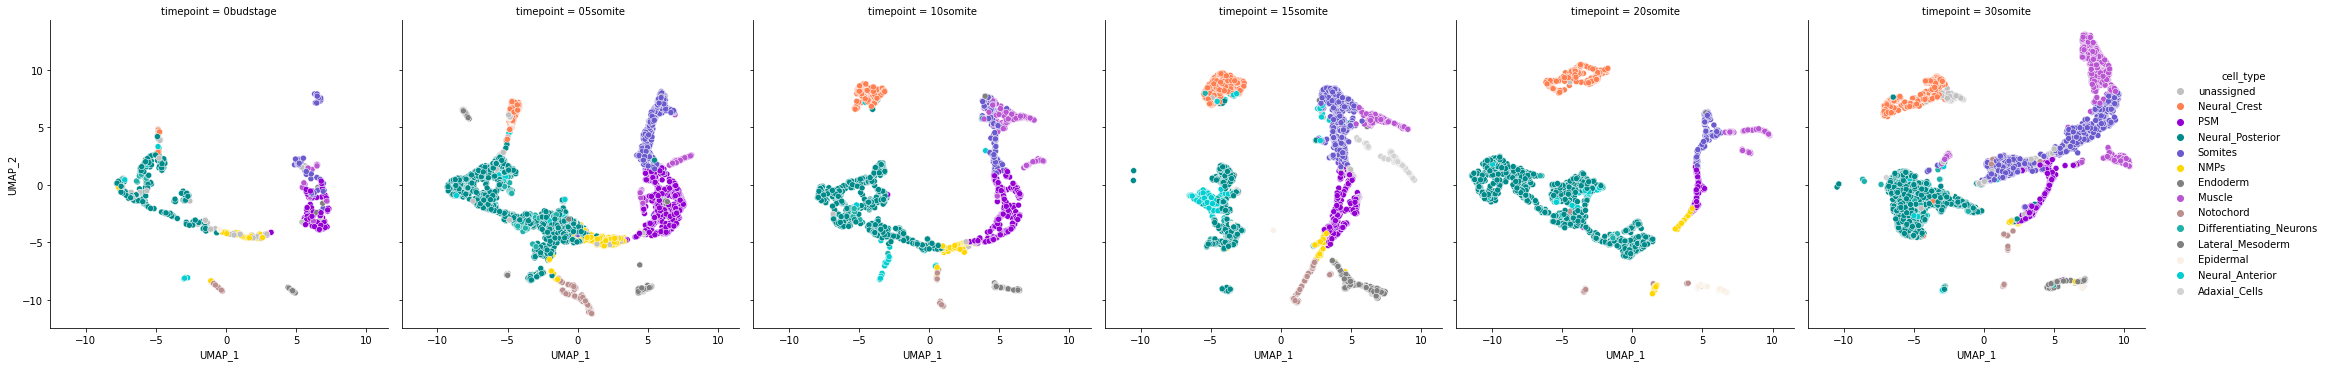

In [9]:
sns.relplot(
    data=aligned_umap.umap_coords, x="UMAP_1", y="UMAP_2",
    col="timepoint", hue="cell_type",
    kind="scatter", palette = palette_celltype
)